# Homework

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import scipy
import scipy.sparse
import scipy.sparse.linalg

1. Load the dataset

In [4]:
dt = pd.read_csv("../data/data.csv")

In [5]:
dt.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [6]:
dt.shape

(42000, 785)

In [7]:
set(dt.label.unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Convert pandas DataFrame to NumPy array

In [8]:
dt = np.array(dt)

2. Split the data in a matrix $X$ with dimensions $d \times N$ and the labels in a column vector $y$. $d = 784$

In [9]:
X = dt[:, 1:]
y = dt[:, 0]

In [10]:
X.shape

(42000, 784)

In [11]:
y.shape

(42000,)

3. Extract all the digits labeled $l$.

In [12]:
l = [0, 6, 9, 4]

mask = [y_i in l for y_i in y] # True il the element in y is equal to l, False otherwise
y = y[mask]
X = X[mask, :]

In [13]:
X.shape

(16529, 784)

4. Split train and test

In [14]:
def train_test_split(X, y, Ntrain):
    # data = np.append(np.array([y]).T, X.T, axis=1)
    data = np.concatenate((y.reshape((-1, 1)), X.T), axis=1)
    np.random.shuffle(data)
    X_train = data[:Ntrain, 1:].T
    X_test = data[Ntrain:, 1:].T
    y_train = data[:Ntrain, 0]
    y_test = data[Ntrain:, 0]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X.T, y, int(X.shape[0] * 0.8))

In [15]:
X_train.shape

(784, 13223)

In [16]:
X_test.shape

(784, 3306)

In [17]:
def compute_class_centroids(X, y):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    return c_k

In [18]:
def convert_centroids_to_dict(labels, Z_c):
    Z_c_dict = {}
    for temp in zip(labels, Z_c.T):
        l, zc = temp
        Z_c_dict[str(l)] = zc
    return Z_c_dict

In [19]:
def PCA(X, y, k):
    c_k = compute_class_centroids(X, y)
    # Center the matrix
    cx = np.array([np.mean(col) for col in X])

    X_c = (X.T - cx).T
    
    U, _, _ = np.linalg.svd(X_c, full_matrices=False) # U_k in R^(d*k)
    U_k = U[:,:k]
    
    Z = U_k.T @ X_c
    Z_c = convert_centroids_to_dict(np.unique(y), U_k.T @ c_k.T)

    return Z, Z_c, U_k.T

In [20]:
def LDA(X, y, k):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    c = np.mean(X, axis=1)

    # Center the class matrices
    X_w = X_temp[0] - c_k[0].reshape((-1, 1))
    for i in range(1, nl):
        X_w = np.concatenate((X_w, X_temp[i] - c_k[i].reshape((-1, 1))), axis=1)

    # Compute S_w
    S_w = X_w @ X_w.T

    # Compute S_b
    X_bar = np.repeat(c_k[0].reshape((-1, 1)), X_temp[0].shape[1], axis=1)
    for i in range(1, nl):
        X_bar_i = np.repeat(c_k[i].reshape((-1, 1)), X_temp[i].shape[1], axis=1)
        X_bar = np.concatenate((X_bar, X_bar_i), axis=1)
    X_barc = X_bar - c.reshape((-1, 1))
    S_b = X_barc @ X_barc.T

    try:
        L = np.linalg.cholesky(S_w)
    except LinAlgError:    
        # Create a matrix to correct S_w to make it positive definite
        eps = 1e-6
        I_eps = np.eye(S_w.shape[0]) * eps
        S_w = S_w + I_eps
        # Decomposition
        L = np.linalg.cholesky(S_w)

    # Compute W
    L_inv = np.linalg.inv(L)
    eig_val, W = scipy.sparse.linalg.eigs(L_inv @ S_b @ L, k=2)
    W = np.real(W)

    # Compute Q.T
    Q_t = (L_inv.T @ W).T

    # Compute the projection of our data
    Z = Q_t @ X
    # and the centroid
    Z_c = convert_centroids_to_dict(labels, Q_t @ c_k.T)

    return Z, Z_c, Q_t

In [21]:
def get_intra_cluster_dists(Z, Z_c):
    # Compute mean distance of the point in a cluster with the centroid
    intra_dists = {}
    for cluster, coord in Z_c.items():
        cluster_points = Z[:, y_train==int(cluster)]
        intra_dists[cluster] = np.mean(np.array([np.linalg.norm(x - Z_c[cluster]) for x in cluster_points.T]))
    return intra_dists

In [22]:
Z, Z_c, Q_t = LDA(X_train, y_train, 2)
Z.shape, Z_c

((2, 13223),
 {'0': array([ 0.03981476, -0.00246562]),
  '4': array([-0.02243513, -0.00796304]),
  '6': array([0.00569046, 0.04131802]),
  '9': array([-0.02283049, -0.01864207])})

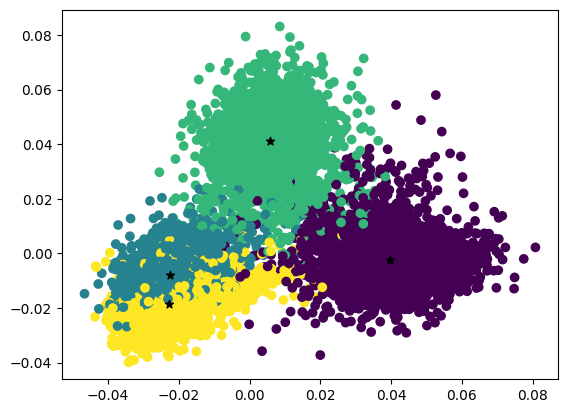

In [23]:
plt.scatter(Z[0, :], Z[1, :], c=y_train)
for key, val in Z_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [24]:
print(get_intra_cluster_dists(Z, Z_c))

{'0': 0.012285577316998907, '4': 0.00777771888365579, '6': 0.011690338321652182, '9': 0.008426320645419965}


In [25]:
Z, Z_c, U_kt = PCA(X_train, y_train, 2)
Z.shape, Z_c

((2, 13223),
 {'0': array([1485.53828942, -305.80186242]),
  '4': array([-25.43224911, -46.65402295]),
  '6': array([ 388.32762271, -679.49353207]),
  '9': array([-45.13962955, -74.85618511])})

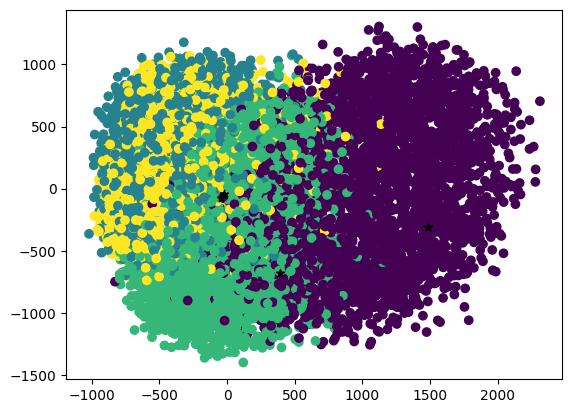

In [26]:
plt.scatter(Z[0, :], Z[1, :], c=y_train)
for key, val in Z_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [27]:
print(get_intra_cluster_dists(Z, Z_c))

{'0': 859.1913171384349, '4': 691.2736453465732, '6': 759.1921455895526, '9': 686.2207620916794}


Compute the distance from the centroids 